# Raport projektu na przedmiot Modelowanie Deterministyczne w semestrze zimowym 2024/2025
## Autor: Filip Rabiega

# Wstęp
Celem projektu jest zastosowanie równania ciepła do symulacji ogrzewania pomieszczeń. W projekcie zostały poruszone dwa zasadnicze problemy badawcze:
1. *Czy grzejnik powinien znajdować się pod oknem?*
2. *Czy warto wyłączać grzejniki przed wyjściem z domu?*

Symulacje dla pierwszego problemu zostały przeprowadzone na uproszczonym modelu składającego się z tylko jednego pokoju, podczas gdy symulacje drugiego zagadnienia zostały przeprowadzone na modelu bazującym na prawdziwym mieszkaniu.
Każdemu z tych zagadnień został poświęcony osobny rozdział w dalszej części raportu.

# Opis projektu

## Rozważania teoretyczne

Klasyczne równanie ciepła ma postać
$$\frac{\partial}{\partial t}u(x,t) = \alpha \Delta u(x,t),$$
gdzie $\alpha$ to *współczynnik przewodnictwa*, a $\Delta$ to laplasjan $\Delta = \frac{\partial^2}{\partial {x_1}^2} + \frac{\partial^2}{\partial {x_2}^2}$. Zakładamy dla uproszczenia, że mieszkanie jest dwuwymiarowe, oraz że $u(x,t)$ oznacza temperaturę w punkcie $x$ w czasie $t$, gdzie $x$ jest wektorem dwuwymiarowym.

Mieszkanie $\Omega \subseteq \mathbb{R}^2$, które interpretujemy jako pewien prostokąt na płaszczyźnie, dzielimy na obszary: pokoje $\mathcal{P}$, grzejniki $\mathcal{G}$, okna $\mathcal{O}$, ściany $\mathcal{S}$ oraz drzwi $\mathcal{D}$. Obszary te nie muszą być rozłączne. 

Do powyższego równania ciepła wprowadzamy modyfikację:
$$\frac{\partial}{\partial t}u(x,t) = \alpha \Delta u(x,t) + f(x,t) \text{   } (\clubsuit),$$
gdzie $f$ jest funkcją symulującą działanie grzejnika w punkcie $x$ i o czasie $t$. Równanie to będzie stosowane do symulacji rozprowadzania się temperatury w pokojach. Dla większości obszaru mieszkania $f \equiv 0$.
Rozchodzenie się ciepła na poszczególnych obszarach w czasie opisujemy następującymi rówaniami:
$$
\begin{cases}
\\ \frac{\partial}{\partial t}u(x,t) = \alpha \Delta u(x,t) + f(x,t), x\in P \in \mathcal{P};
\\ u(x,t) = T_{out} (t), x \in O \in \mathcal{O};
\\ \nabla u \cdot n = 0, x \in S \in \mathcal{S};
\\ u(x,t) = \frac{1}{|D|} \int_{D} u(s,t) ds, x\in D \in \mathcal{D};
\\ u(x,0) = u_{0}(x), x\in \Omega,
\end{cases}
$$

gdzie $T_{out} (t)$ to temperatura na dworze w czasie $t$ oraz $n$ to wektor normalny do ściany.

Równania te mówią nam, że:
- w pokojach temperatura rozchodzi się zgodnie z równaniem $(\clubsuit)$;
- okna zawsze przyjmują temperaturę, która panuje na zewnątrz;
- ściany są idealnymi izolatorami (warunek brzegowy von Neumanna);
- temperatura równo rozprzestrzenia się w drzwiach.

### Opis metody numerycznej

Metodą numeryczną, którą wykorzystamy do rozwiązania zagadnienia jest metoda różnic skończonych. Oto wzór, którego użyjemy do symulacji dyfuzji ciepła:
$$
u(x,y,t+h_t) = u(x,y,t) + \frac{\alpha h_t}{h_x^2} \Big( u(x+h_x, y, t) + u(x-h_x, y, t) + u(x, y-h_x, t) + u(x,y+h_x, t) - 4 u(x,y,t) \Big) + h_t f(x,t) \text{      } (\spadesuit).
$$

Żeby powyższy wzór był stabilny musi zachodzić poniższa nierówność:
$$
\frac{\alpha h_t}{{h_x}^2} < \frac{1}{2} \text{    }(\heartsuit).
$$

Więcej na temat tej metody oraz wyprowadzenie powyższego wzoru można znaleźć w pracy pod poniższym linkiem: [LINK](https://www.researchgate.net/publication/265202152_Finite-Difference_Approximations_to_the_Heat_Equation). Wypisane powyżej wzory mają odpowiednio numery (16) i (18) w podanej pracy.

## Rozważania implementacyjne

Całość projektu została napisana w języku Python. Wykorzystany został paradygmat programowania obiektowego. Do implementacji numerycznej użyto funkcjonalności z biblioteki *NumPy*, z kolei do prezentacji wyników użyto wykresów wygenerowanych przez bibliotekę *MatPlotLib*. Mieszkanie oraz każdy rodzaj obszaru z poprzedniego podpunktu jest pewną klasą zawierającą informacje potrzebne do symulacji; w szczególności klasa `Apartment` zawiera listy obiektów przynależących do klas reprezentujących pokoje, grzejniki *et cetera*. Temperatura w symulacji jest wyrażona w stopniach Kelwina. Ściany nie są osobną klasą; zamiast tego są prawie całkowicie pomijane w symulacji. Żeby zasymulować warunek von Neumanna kopiujemy temperaturę z najlbiższego pola przynależącego do pewnego pokoju.

Z doświadczenia wiemy, że temperatura na zewnątrz zmienia się w ciągu doby, osiągając swoje minimum o świcie, następnie stopniowo rośnie i osiąga swoje maksimum po południu, po czym znowu spada. Temperatura na zewnątrz $T_{out} (t)$ będzie zatem opisywana przez funkcję postaci $f(t) = C - 5\sin(\frac{\pi t}{12})$, gdzie $C$ to będzie średnia temperatura w czasie dnia wyrażona w stopniach Kelwina. Funkcje tej postaci mają pożądaną formę.

### Dyskretyzacja przestrzeni

Zakładamy, że mieszkanie jest reprezentowane przez pewną kratę punktów tworzących podział przestrzeni na przystające kwadraty. Obliczenia są wykonywane jedynie na kracie. Jest to standardowa metoda dyskretyzacji przestrzeni w celach obliczeniowych. W naszych symulacjach $h_{x} = 0.1$ to długość boku jednego kwadratu, wartość ta odpowiada $10cm$ w rzeczywistości.

### Dokładniejszy opis klas

#### Mieszkanie
`Apartment` to najbardziej rozbudowana klasa w projekcie. Obiekty przynależące do tej klasy zawierają następujące parametry:
1. `base_temp`: początkowa temperatura w mieszkaniu, zakładamy, że jest stała;
2. `coeff`: współczynnik $\alpha$ używany w równaniu przewodnictwa cieplnego;
3. `temp_outside`: funkcja symulujące zmieniającą się temperaturę na zewnątrz w ciągu doby;
4. `size`: wymiary macierzy reprezentującej mieszkanie;
5. `hx`: współczynnik używany w równaniu $(\spadesuit)$;
6. `T`: czas symulacji wyrażony w godzinach;
7. `ht`: długość odstępu czasu, na które dzielimy `T`;

Dodatkowo funkcja `__init()` inicjalizuje następujące parametry:
1. `n_timeslips`: liczba iteracji metody $(\spadesuit)$;
2. `rooms`: lista pokoi, początkowo pusta;
3. `radiators`: lista grzejników, początkowo pusta;
4. `windows`: lista okien, początkowo pusta;
5. `doors`: lista drzwi, początkowo pusta;
6. `Matrix`: trójwymiarowa macierz z biblioteki *NumPy*, na której wykonywana jest symulacja cieplna mieszkania. Pierwsza wszpółrzędna to numer iteracji algorytmu ($\spadesuit$), tzn. czas, podczas gdy kolejne dwie współrzędne przedstawiają dyskretyzację mieszkania.

Klasa `Apartment` zawiera następujące metody:
1. `add_room()`, `add_radiator()`, `add_window()`, `add_door()`, które służą do dodawania poszczególnych rodzajów obiektów do mieszkania;
2. `avg_temperature()`, która służy do wyliczenia średniej temperatury w mieszkaniu;
3. `simulate()`, która pozwala na wykonanie symulacji.

#### Pokoje
Klasa `Room` składa się z następujących parametrów:
1. `x_coords`: opisują odcięte lewego dolnego oraz prawego górnego kąta pokoju;
2. `y_coords`: opisują rzędne lewego dolnego oraz prawego górnego kąta pokoju.

Klasa ta opisuje rozmieszczenie pokoi w mieszkaniu na podstawie dwóch par współrzędnych w rogach pokoju. Metoda `Apartment.simulate()` używa wzoru $(\spadesuit)$ do wyliczenia rozmieszczenia temperatury w kolejnych iteracjach.

#### Grzejniki
Klasa `Radiator` składa się z następujących parametrów:
1. `x_coords`: opisują odcięte lewego dolnego oraz prawego górnego kąta grzejnika;
2. `y_coords`: opisują rzędne lewego dolnego oraz prawego górnego kąta grzejnika;
3. `power`: trójargumentowa funkcja opisująca moc (ciepło oddawane) grzejnika w punkcie `(x, y)` i w czasie `t`.

Grzejnik po prostu dodaje temperaturę w każdym swoim punkcie zgodnie z funkcją `power`.

#### Okna
Klasa `Window` składa się z następujących parametrów:
1. `x_coords`: opisują odcięte lewego dolnego oraz prawego górnego kąta okna;
2. `y_coords`: opisują rzędne lewego dolnego oraz prawego górnego kąta okna.

W kolejnych iteracjach temperatura okien jest ustawiana na temperaturę na zewnątrz zgodnie z funkcją `self.temp_outside()`.

#### Drzwi
Klasa `Door` składa się z następujących parametrów:
1. `x_coords`: opisują odcięte lewego dolnego oraz prawego górnego kąta drzwi;
2. `y_coords`: opisują rzędne lewego dolnego oraz prawego górnego kąta drzwi.
3. `direction`: wartość opisująca skierowanie drzwi (poziome lub pionowe).

Temperatura drzwi jest uśrednioną temperaturą z góry i z dołu dla poziomego skierowania drzwi oraz z lewa i prawa dla pionowego skierowania drzwi.

### Krótki opis metody `Apartment.simulate()`

Metoda ta jest sercem całego projektu, dlatego zawieramy krótki rozdzialik jej poświęcony. Działa ona osobno dla każdego rodzaju obiektów w kolejności: `Room`, `Radiator`, `Window`, `Door`. Metoda ta w kolejnych iteracjach `k in range(self.n_timeslips)` wylicza kolejne wartości macietzy `self.Matrix[k]` na podstawie wartości macierzy `self.Matrix[k-1]`. `k=0` jest rozpatrzony jako osobny przypadek.
Dla każdego rodzaju obiektów `Apartment.simulate()` zachowuje się zgodnie z opisami klas powyżej. Grzejniki po prostu dodają temperaturę zgodnie ze swoją funkcją `power`, okna przyjmują temperaturę na zewnątrz, a temperatura drzwi jest ujednolicana na każdym kroku.

# Wyniki eksperymentów

Poniżej przedstawimy opis oraz wyniki eksperymentów numerycznych zapowiedzianych we wstępie.

## *Czy grzejnik powinien znajdować się pod oknem?*

### Opis
W wielu polskich domach grzejniki znajdują się pod oknami. W tym eksperymencie sprawdzimy, czy takie ustawienie grzejników jest odpowiednie. 

Nasz eksperyment przeprowadzimy dla mieszkania składającego się z tylko jednego pokoju. W pokoju tym będzie dokładnie jeden grzejnik oraz dokładnie jedno okno. Rozważymy dwa warianty rozmieszczenia grzejnika: w jednym będzie się on znajdował bezpośrednio pod oknem, a w drugim będzie on bezpośrednio naprzeciwko okna. Eksperymenty numeryczne będą przeprowadzone dla $T = 24$ oraz $T_{out}(t) = 288.15 - 5\sin(\frac{\pi t}{12})$. Mieszkanie ma wymiary $25 m^2$.

W każdej symulacji mieszkanie ma parametry
```
apartment = Apartment(
     celcius_to_kelvin(20), # temperatura początkowa w mieszkaniu
     0.25,                  # współczynnik przewodnictwa
     T_out,                 # temperatura na zewnątrz
     (50, 50),              # wymiary macierzy symulacji
     0.1,                   # hx
     24,                    # czas T w godzinach
     0.01,                  # ht
)

```

Należy zauważyć, że z tak dobranymi parametrami nierówność $(\heartsuit)$ jest spełniona.

Zakładamy, że moc grzejnika jest stała i wynosi ona $1500\frac{W}{m^2}$, co jest mocą potrzebną na ogrzanie naszego pokoju ([LINK](https://luxrad.com/wylicz-moc/)).
Poniższe szkice przedstawiają położenie okna i grzejnika w obu przypadkach:


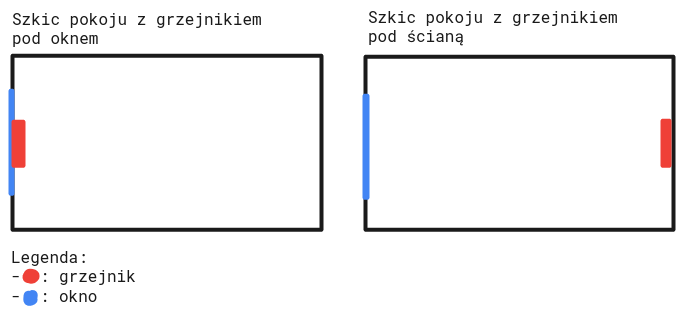


### Wyniki

Temperatura na wykresach została zamieniona na stopnie Celsjusza:

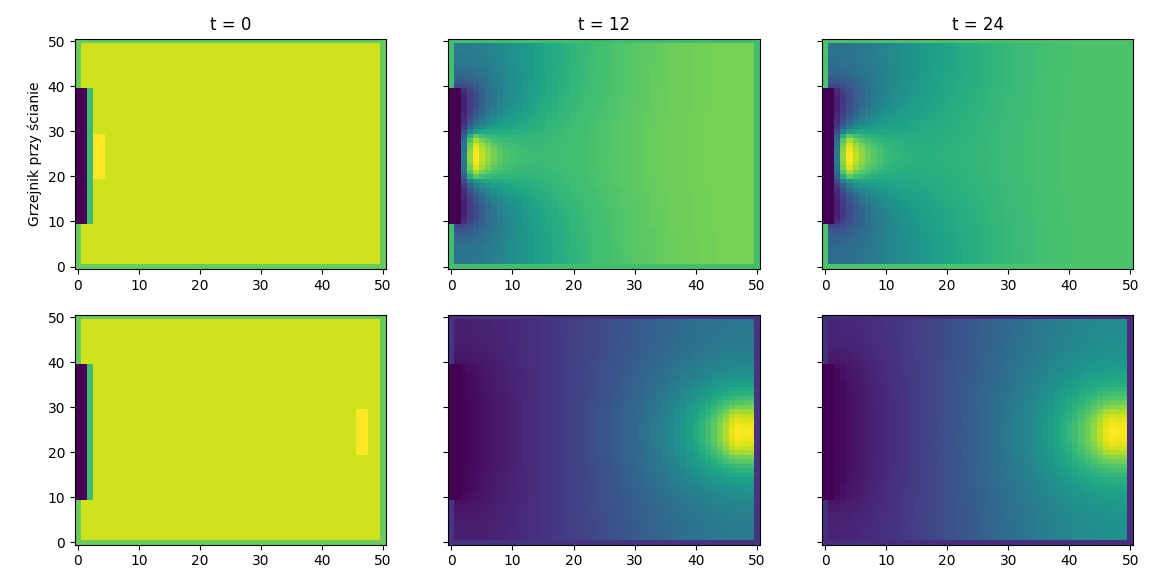

Pierwszy rząd wykresów przedstawia symulację wtedy kiedy grzejnik znajduje się pod oknem, a drugi rząd wykresów przedstawia symulację, gdy grzejnik znajduje się pod ścianą. Im cieplejszy kolor, tym wyższa temperatura.

#### Wnioski

Jak wskazują wykresy, zdecydowanie bardziej opłaca się mieć grzejnik pod oknem aniżeli naprzeciwko okna. Na początku temperatura jest niemal równa w całym mieszkaniu, jednak po 12 godzinach w mieszkaniu z grzejnikiem pod oknem jest cieplej.

## *Czy warto wyłączać grzejniki przed wyjściem z domu?*

### Opis
W tym eksperymencie sprawdzimy, czy bardziej opłaca się zostawić odkręcone pokrętła naszego grzejnika pod naszą nieobecność w domu czy też podgrzać dom na nowo po naszej nieobecności, na przykład po powrocie ze szkoły czy pracy. W tym celu rozważymy mieszkanie opisane rysunkiem znajdującym się niżej oraz trzy warianty temperatury na zewnątrz: zimnej (ok. $0℃$), bardzo zimnej ($-20℃$)  oraz bardzo bardzo zimnej ($-50℃$), a więc $T^{1}_{out}(t) = 273.15 - 5\sin(\frac{\pi t}{12})$, $T^{2}_{out}(t) = 253.15 - 5\sin(\frac{\pi t}{12})$, $T^{3}_{out}(t) = 223.15 - 5\sin(\frac{\pi t}{12})$ - wszystkie te wartości są w stopniach Kelwina. W każdym z trzech wariantów temperatura będzie nieco się wahać, osiągając swoje minimum nad ranem oraz maksimum po południu. Podobnie jak wcześniej zakładamy że standardowa moc grzejnika to $1500 \frac{W}{m^2}$.

W każdej symulacji mieszkanie ma parametry
```
apartment = Apartment(
     celcius_to_kelvin(20), # temperatura początkowa w mieszkaniu
     0.25,                  # współczynnik przewodnictwa
     T_out,                 # temperatura na zewnątrz
     (100, 50),             # wymiary macierzy symulacji
     0.1,                   # hx
     24,                    # czas T w godzinach
     0.01,                  # ht
)
```

Należy zauważyć, że z tak dobranymi parametrami nierówność $(\heartsuit)$ jest spełniona.

Dla każdego z tych wariantów temperatur na zewnątrz rozważymy dwa scenariusze: w jednym zakręcamy pokrętła w czasie $t = 8$, a więc o godzine ósmej, i rozkręcamy je ponownie, tym razem na podwójną moc, w czasie $t = 16$, po przyjściu z pracy. W drugim grzejniki działają z tą samą mocą przez całą dobę. Sprawdzimy, który wariant jest korzystniejszy, ponieważ zużycie energii będzie takie samo.

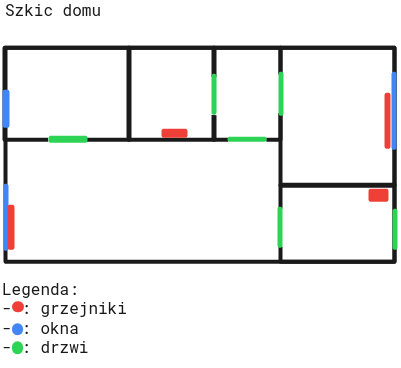


Dokładniejszy opis pokoi na macierzy symulacji można znaleźć w kodzie źródłowym.

### Wyniki

Poniższe wykresy przedstawiają rozkład temperatury w momentach $t = 0,12,24$ dla $T^{i}_{out}$, $i=1,2,3$. Temperatura na wykresach została zamieniona na stopnie Celsjusza:
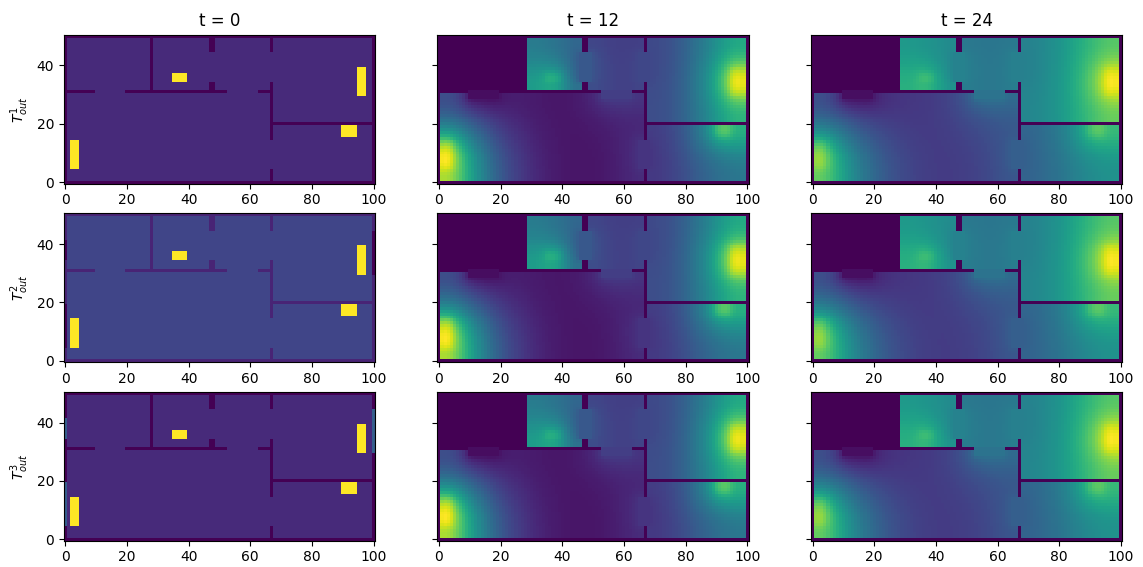

Jak widać wykresy w poszczególnych wierszach niewiele różnią się między sobą.



Te wykresy z kolei przedstawiają rozkład temperatury przy założeniu, że grzejniki zostały zaktęcone po czasie $t=8$:
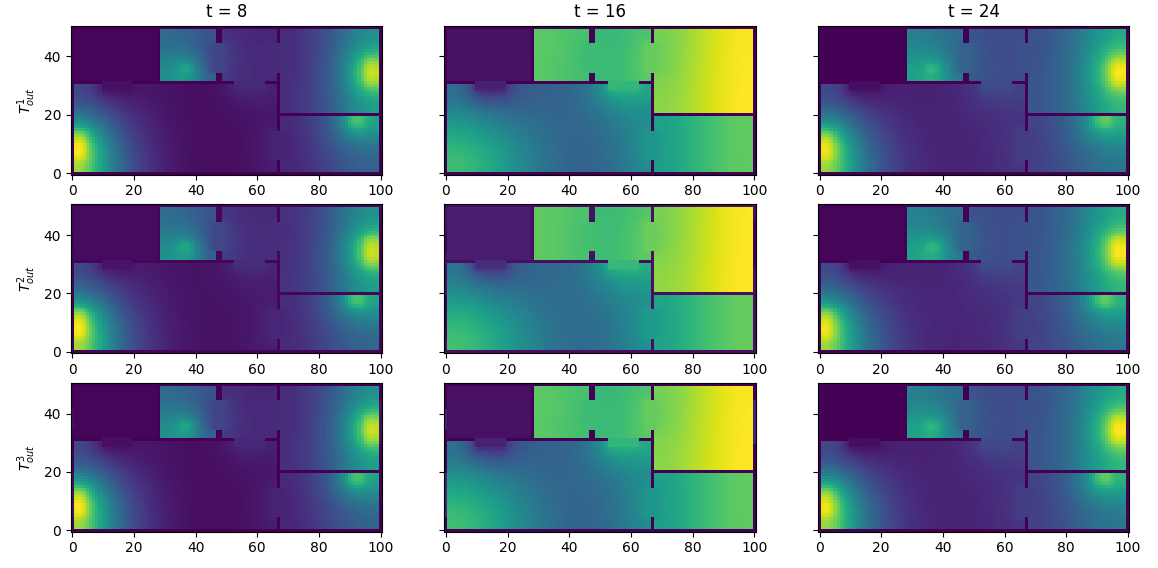

Środkowe wykresy znacząco różnią się od pozostałych. Przedstawiają one sytuację w której temperatura, a więc energia, miała czas żeby się rozprzestrzenić w mieszkaniu, w którym nie działają kaloryfery. Po czasie $t = 16$ grzejniki zostają włączone z podwojoną mocą. W każdym przypadku w lewym górnym pokoju, w którym nie ma grzejnika i jest okno, jest bardzo zimno.

#### Wnioski

W obu przypadkach rozkład energii w czasie $t=24$ jest identyczny, zatem nasuwa się wniosek, że oba sposoby ogrzewania są porównywalnie dobre. W czasie $t=16$ w drugim przypadku średnia temperatura w mieszkaniu spadła nieznacząco.